# Time series visualisations
This notebook houses all graphs for time series and various other visualisations

In [116]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from functools import reduce
from scipy.spatial.distance import pdist, squareform
from statsmodels.tsa.seasonal import STL
from adjustText import adjust_text
import matplotlib.colors as mcolors

In [2]:
#import files
df_valais = pd.read_csv('../../data/filtered/merged_valais.csv')
station_list = pd.read_csv('../../data/clean/valais_stations.csv')

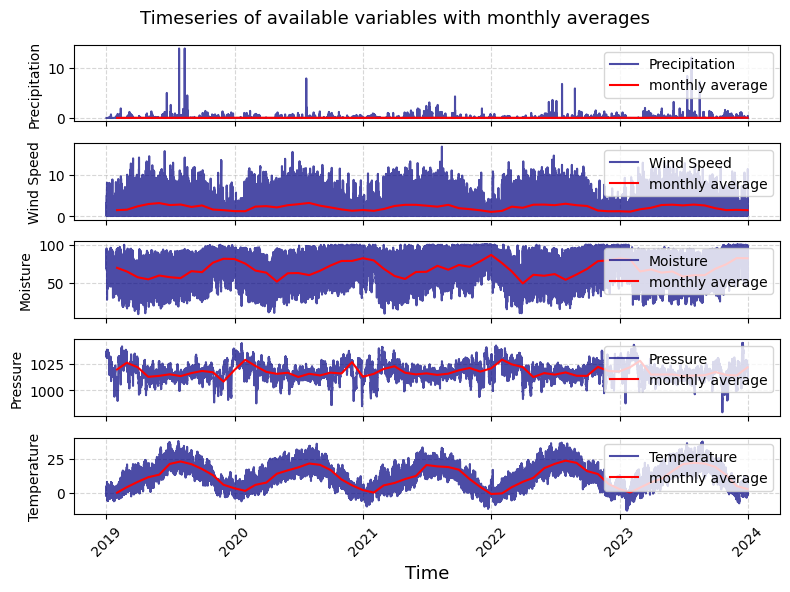

In [49]:
# Filter data for the given station
sion_data = df_valais[df_valais['station'] == 'SIO'].copy()

# Compute wind speed
sion_data['speed'] = np.sqrt(sion_data['North']**2 + sion_data['East']**2)
sion_data['time'] = pd.to_datetime(sion_data['time'], format='%Y%m%d%H%M')
sion_data = sion_data.set_index('time')

# Compute monthly averages
monthly_avg = sion_data[['precip', 'speed', 'moisture', 'pression', 'temperature']].resample('ME').mean()

# Create figure with shared x-axis
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)

vars=['precip', 'speed', 'moisture', 'pression', 'temperature']
labels=['Precipitation', 'Wind Speed', 'Moisture', 'Pressure', 'Temperature']

for i, (ax, var, label) in enumerate(zip(axes, vars, labels)):
    ax.plot(sion_data.index, sion_data[var], label=label, alpha=0.7, color='navy')
    ax.plot(monthly_avg.index, monthly_avg[var], label="monthly average", color='red')
    ax.set_ylabel(label, fontsize=10)
    ax.legend(loc='upper right')
    ax.grid(True, linestyle="--", alpha=0.5)

axes[-1].set_xlabel("Time", fontsize=13)
plt.suptitle('Timeseries of available variables with monthly averages', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../../report/figures/all_vars_sion.pdf')
plt.show()

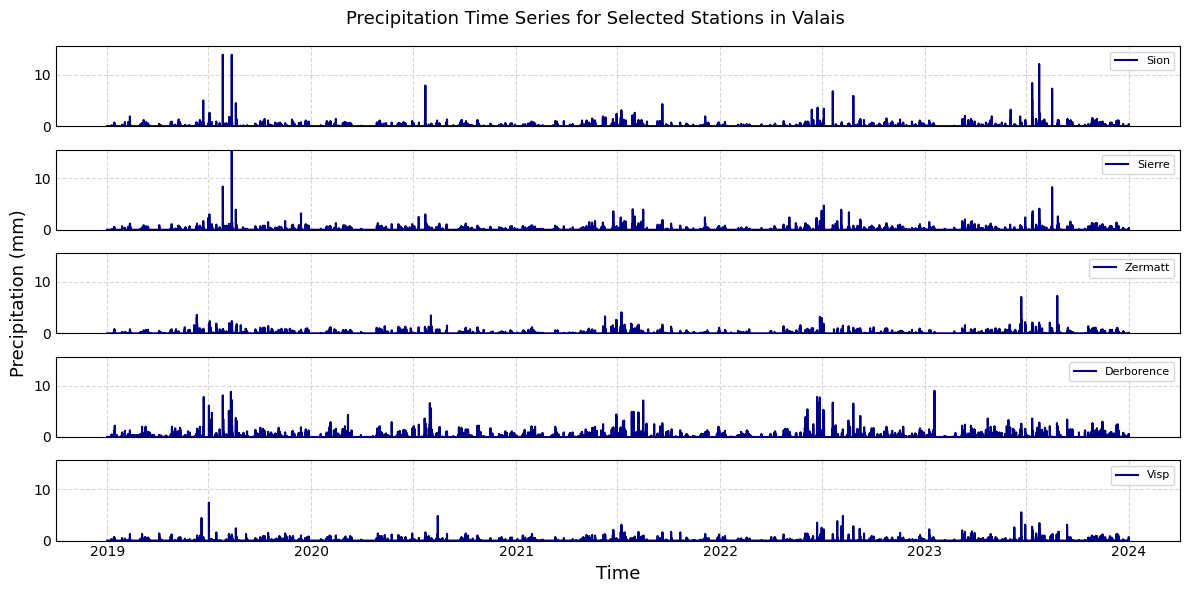

In [46]:

valais_stations = ["SIO","VSSIE", "ZER", "VSDER", "VIS"]
station_name = ["Sion", "Sierre", "Zermatt", "Derborence", "Visp"]

precip_filter = df_valais[df_valais['station'].isin(valais_stations)]
precip_wide = precip_filter.pivot(index='time', columns='station', values='precip')

precip_wide.index = pd.to_datetime(precip_wide.index, format='%Y%m%d%H%M')

y_max = precip_wide.max().max()

fig, axes = plt.subplots(len(valais_stations), 1, figsize=(12, 6), sharex=True)

for ax, station, name in zip(axes, valais_stations, station_name):
    ax.plot(precip_wide.index, precip_wide[station], label=name, color='navy')
    ax.xaxis.set_major_locator(mdates.YearLocator(1))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 7))) 
    ax.set_ylim(0, y_max) 
    ax.legend(loc="upper right", fontsize=8)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(True, which='both', linestyle="--", alpha=0.5)

# Set common labels
axes[2].set_ylabel("Precipitation (mm)", fontsize=13)
axes[-1].set_xlabel("Time", fontsize=13)
fig.suptitle("Precipitation Time Series for Selected Stations in Valais", fontsize=13)

plt.tight_layout()  
plt.savefig("../../report/figures/valais_stations_ts.pdf", dpi=100)
plt.show()

In [59]:
total_counts = df_valais.groupby('station').size()
zero_counts = df_valais[df_valais['precip'] == 0].groupby('station').size()

# Combine into a DataFrame and compute percentages
zero_rain_summary = pd.DataFrame({
    'zero_rain_count': zero_counts,
    'total_obs': total_counts
})

zero_rain_summary['percent_zero_rain'] = 100 * zero_rain_summary['zero_rain_count'] / zero_rain_summary['total_obs']

# Sort by percentage (optional)
zero_rain_summary = zero_rain_summary.sort_values('percent_zero_rain', ascending=False)

print(zero_rain_summary)


         zero_rain_count  total_obs  percent_zero_rain
station                                               
VSMAT             252494     262944          96.025770
VSVIS             251542     262944          95.663715
GRC               251412     262944          95.614275
VSSIE             251358     262944          95.593739
VSERG             250764     262944          95.367835
VSSAB             250679     262944          95.335509
SIO               250621     262944          95.313451
VIS               250213     262944          95.158285
ZER               249800     262944          95.001217
VSFIN             249175     262944          94.763524
MTE               248968     262944          94.684800
VSISE             248897     262944          94.657798
VSVER             248579     262944          94.536860
EVO               248189     262944          94.388539
MOB               247860     262944          94.263417
ORS               247724     262944          94.211695
VSTUR     

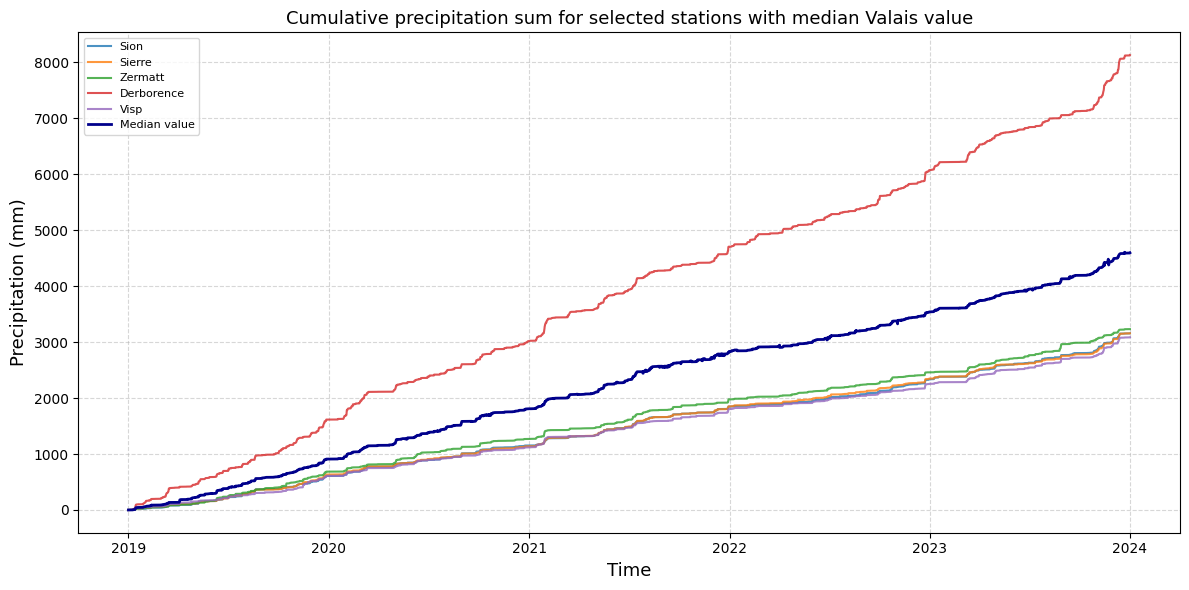

In [43]:
valais_stations = ["SIO","VSSIE", "ZER", "VSDER", "VIS", 'median']
station_name = ["Sion", "Sierre", "Zermatt", "Derborence", "Visp", 'Median value']

precip_wide = df_valais.pivot(index='time', columns='station', values='precip')
precip_wide.index = pd.to_datetime(precip_wide.index, format='%Y%m%d%H%M')
monthly_precip = precip_wide.cumsum()

monthly_precip['median'] = monthly_precip.median(axis=1)

fig, ax = plt.subplots(figsize=(12,6))

for station, name in zip(valais_stations, station_name):
    if station =='median':
        ax.plot(monthly_precip.index, monthly_precip.loc[:, station], label=name, linewidth=2, color='darkblue')
    else:
        ax.plot(monthly_precip.index, monthly_precip.loc[:, station], label=name, alpha=0.8)

ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Precipitation (mm)", fontsize=13)
ax.set_title("Cumulative precipitation sum for selected stations with median Valais value", fontsize=13)
ax.legend(loc="upper left", ncol=1, fontsize=8)
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("../../report/figures/cumsum_valais_ts.pdf")
plt.show()

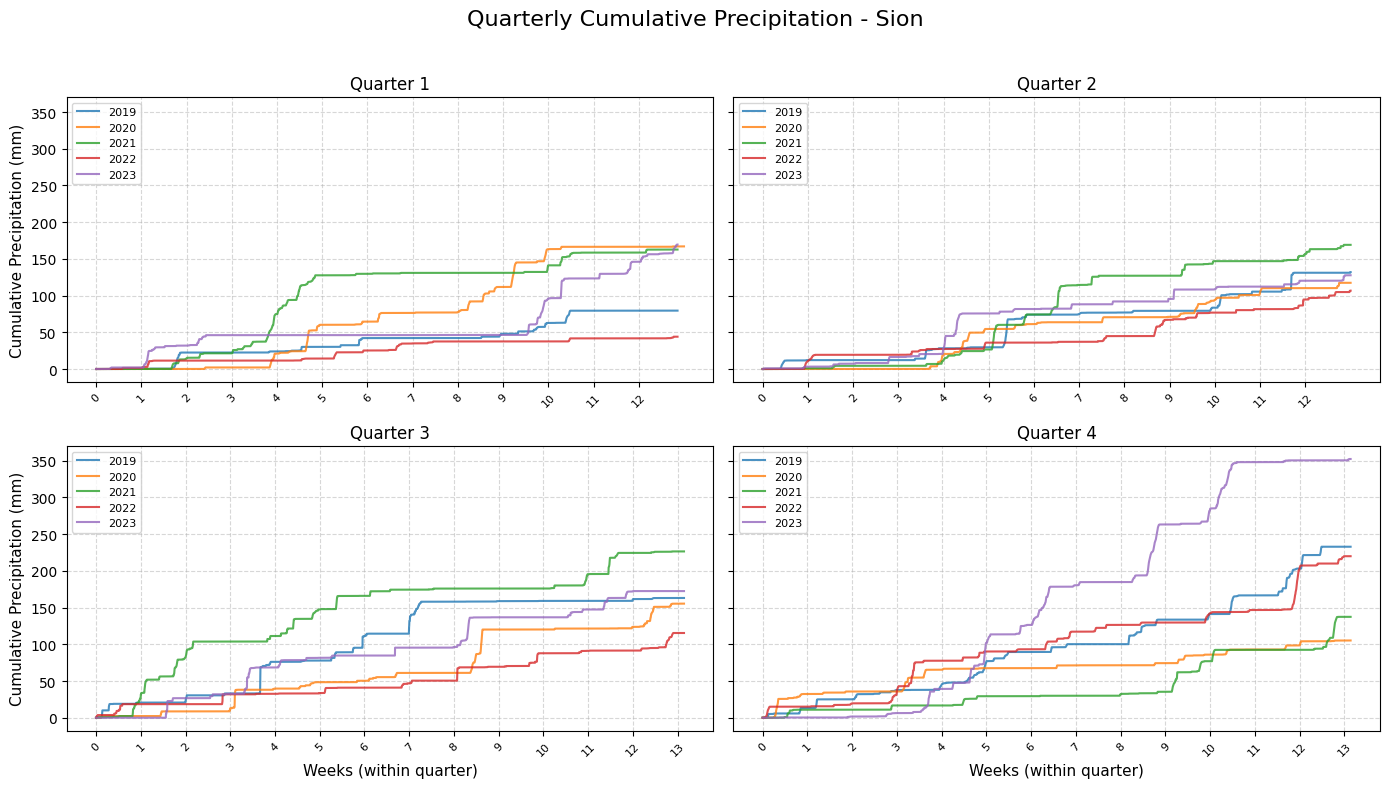

In [13]:
precip_filter = df_valais[df_valais['station'] == 'SIO'].copy()
precip_filter.index = pd.to_datetime(precip_filter['time'], format='%Y%m%d%H%M')

# Create quarter and year columns
precip_filter['quarter'] = precip_filter.index.to_period('Q')
precip_filter['year'] = precip_filter.index.to_period('Y')

# Compute cumulative precipitation within each quarter
precip_filter['cumsum_precip'] = precip_filter.groupby(['year', 'quarter'])['precip'].cumsum()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=False, sharey=True)
axes = axes.flatten()

# Iterate through quarters (1 to 4)
for i, q in enumerate([1, 2, 3, 4]):
    ax = axes[i]
    quarter_data = precip_filter[precip_filter.index.quarter == q]

    # Plot cumulative precipitation for each year within the quarter
    for year in quarter_data['year'].unique():
        yearly_data = quarter_data[quarter_data['year'] == year]
        yearly_data = yearly_data.reset_index(drop=True)
        ax.plot(yearly_data.index, yearly_data['cumsum_precip'], label=str(year), alpha=0.8)

    # Axis formatting
    ax.set_title(f"Quarter {i + 1}", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Add ticks and labels
    ax.set_xticks(range(0, len(yearly_data), 1008))  # adjust number of ticks
    ax.set_xticklabels([f"{int(x/1008)}" for x in range(0, len(yearly_data), 1008)], rotation=45, fontsize=8)

    ax.legend(loc="upper left", fontsize=8)

# X labels only on bottom row
for ax in [axes[2], axes[3]]:
    ax.set_xlabel("Weeks (within quarter)", fontsize=11)

# Y labels only on left column
for ax in [axes[0], axes[2]]:
    ax.set_ylabel("Cumulative Precipitation (mm)", fontsize=11)

# Title and layout
fig.suptitle("Quarterly Cumulative Precipitation - Sion", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make space for suptitle
plt.savefig("../../report/figures/cumsum_quarter_sion.pdf")
plt.show()


C:\Users\elwin\AppData\Local\Temp\ipykernel_3096\1238866587.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", ncol=1, fontsize=8)


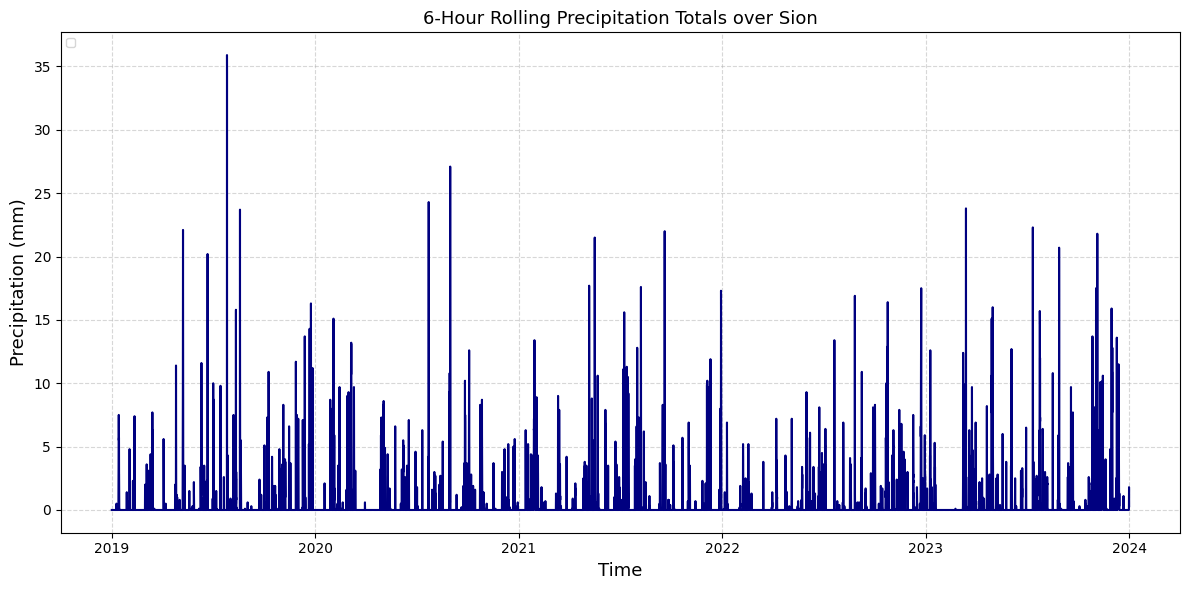

In [53]:
#attempting to do a rolling window graph
only_sion = df_valais[df_valais['station'] == 'SIO'].copy()
only_sion['time'] = pd.to_datetime(only_sion['time'], format='%Y%m%d%H%M')

# Resample to hourly total precipitation
df_hourly = (
    only_sion
    .set_index('time')
    .resample('h')
    .agg({'precip': 'sum'})
)

# Compute rolling 6-hour total (including current hour)
df_hourly['rolling_6h'] = df_hourly['precip'].rolling(window=6, min_periods=1).sum()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df_hourly['rolling_6h'], color='navy')

ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Precipitation (mm)", fontsize=13)
ax.set_title("6-Hour Rolling Precipitation Totals over Sion", fontsize=13)
ax.legend(loc="upper left", ncol=1, fontsize=8)
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("../../report/figures/rolling_six_sum.pdf")
plt.show()

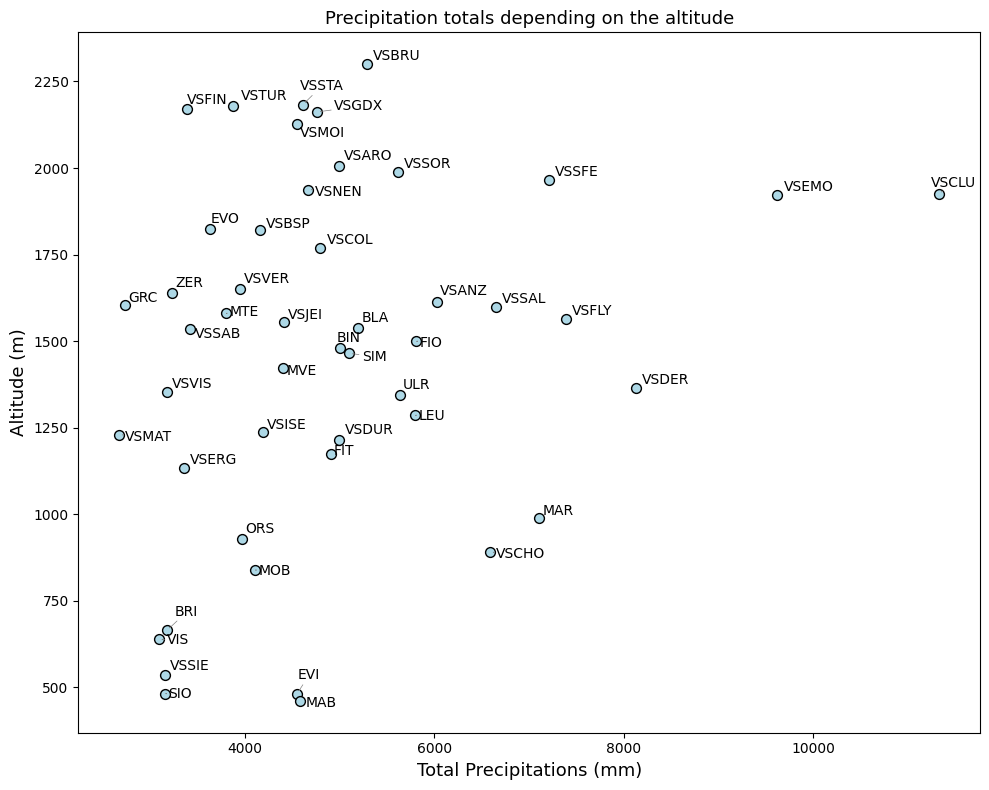

In [21]:
from adjustText import adjust_text

precip_copy = df_valais.copy().drop(columns=['time'], errors='ignore')

mean_precip = precip_copy.groupby('station')['precip'].sum().reset_index()
merged_df = station_list[['station', 'altitude']].merge(mean_precip, on='station', how='inner')

fig, ax = plt.subplots(figsize=(10,8))

# Scatter plot
ax.scatter(data=merged_df, x='precip', y='altitude', facecolors='lightblue', edgecolors='black', s=50)

# Use adjustText to place labels without overlap
texts = []
for i in range(len(merged_df)):
    texts.append(ax.text(merged_df['precip'][i], merged_df['altitude'][i], merged_df['station'][i]))

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Labels and title
ax.set_xlabel("Total Precipitations (mm)", fontsize=13)
ax.set_ylabel("Altitude (m)", fontsize=13)
ax.set_title("Precipitation totals depending on the altitude", fontsize=13)

plt.tight_layout()
plt.savefig("../../report/figures/sum_precip_altitude_vs.pdf")
plt.show()

## Temperature

In [101]:
ok_dataset = pd.read_csv('../../data/clean/valais_clean.csv')
clean = ok_dataset[['temperature', 'station', 'time']]
temperature_fake = clean.merge(station_list, on='station', how='left')

temperature = temperature_fake[temperature_fake['temperature_bool']==True]

In [102]:
temperature['station'].unique()

array(['BIN', 'BLA', 'EVI', 'EVO', 'GRC', 'MAR', 'MOB', 'MTE', 'MVE',
       'SIM', 'SIO', 'ULR', 'VIS', 'ZER'], dtype=object)

In [ ]:
#Highest temperature recorded
temperature = df_valais[['temperature', 'station', 'time']]
temp1 = temperature[temperature['station']!='SIO']
temp1.sort_values('temperature', ascending=False).head(10)

In [103]:
temps = temperature.copy()
temps['time'] = pd.to_datetime(temps['time'], format='%Y%m%d%H%M')

df_daily = (
    temps
    .groupby('station')
    .resample('D', on='time')
    .agg(
        temp_min=('temperature', 'min'),
        temp_max=('temperature', 'max'),
        temp_avg=('temperature', 'mean')
    )
    .reset_index()
)

In [104]:
#we take the average by station, we'll get an overall average and then get the altitude
avg_overall = (df_daily[['station', 'temp_min', 'temp_max', 'temp_avg']]
               .groupby('station')
               .aggregate('mean'))
print(avg_overall.to_latex(index=True, 
                           caption="Minimum, Maximum and Mean values over the period", 
                           label="tab:avg_stations_temp",
                           float_format="{:.2f}".format))

\begin{table}
\caption{Minimum, Maximum and Mean values over the period}
\label{tab:avg_stations_temp}
\begin{tabular}{lrrr}
\toprule
 & temp_min & temp_max & temp_avg \\
station &  &  &  \\
\midrule
BIN & 1.61 & 10.83 & 5.99 \\
BLA & 2.03 & 10.75 & 6.24 \\
EVI & 7.95 & 16.25 & 11.80 \\
EVO & 1.91 & 10.12 & 5.62 \\
GRC & 2.80 & 11.41 & 6.57 \\
MAR & 6.26 & 13.78 & 9.49 \\
MOB & 3.70 & 14.76 & 8.71 \\
MTE & 0.78 & 10.57 & 5.20 \\
MVE & 2.67 & 12.05 & 7.24 \\
SIM & 4.31 & 11.08 & 7.54 \\
SIO & 5.95 & 17.71 & 11.57 \\
ULR & -0.90 & 11.76 & 5.16 \\
VIS & 4.36 & 16.91 & 10.77 \\
ZER & 1.32 & 11.40 & 5.73 \\
\bottomrule
\end{tabular}
\end{table}



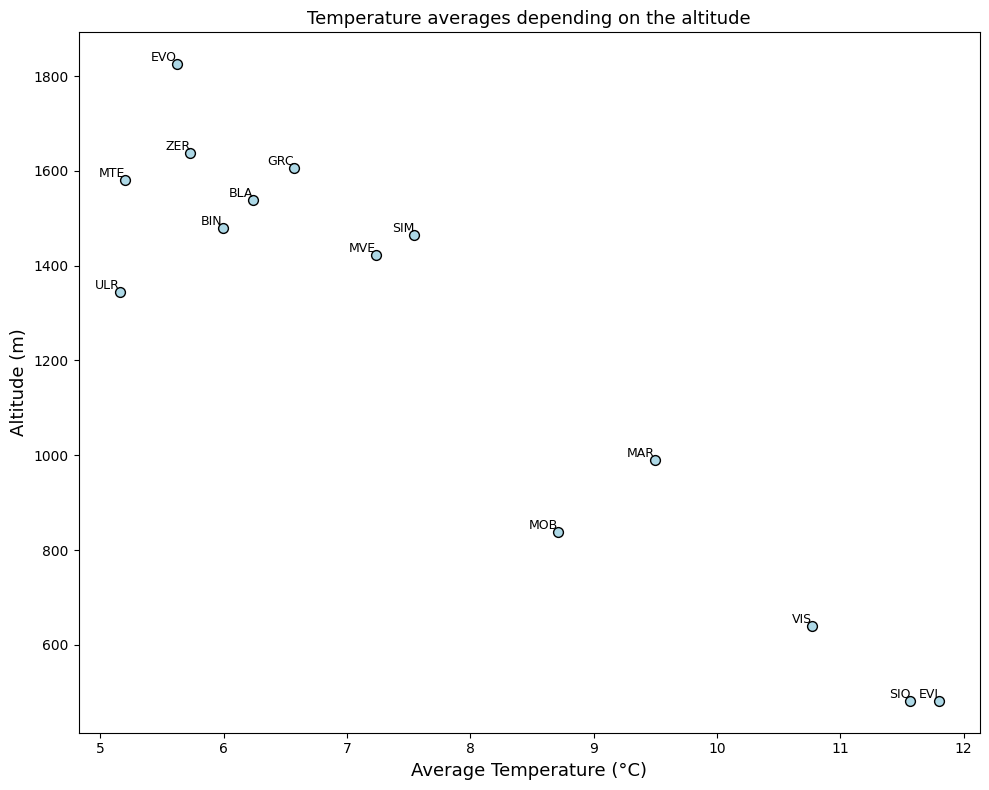

In [105]:
#temperature versus altitude
station_alt = station_list[['station', 'altitude']]
alt_temp = avg_overall.merge(station_alt, on='station', how='left')
alt_temp
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(data=alt_temp, x='temp_avg', y='altitude', facecolor='lightblue', edgecolor='black', s=50)
for _, row in alt_temp.iterrows():
    ax.text(row['temp_avg'], row['altitude'], row['station'], fontsize=9, ha='right', va='bottom')
 
ax.set_xlabel("Average Temperature (°C)", fontsize=13)
ax.set_ylabel("Altitude (m)", fontsize=13)
ax.set_title("Temperature averages depending on the altitude", fontsize=13)

plt.tight_layout()
plt.savefig("../../report/figures/avg_temp_vs_alt.pdf")
plt.show()

In [107]:
summary_counts = df_daily.groupby('station').agg(
    summer_days = ('temp_max', lambda x: (x >= 25).sum()),
    hot_days = ('temp_max', lambda x: (x >= 30).sum()),
    tropical_nights = ('temp_min', lambda x: (x >= 20).sum()),
    frost_days = ('temp_min', lambda x: (x < 0).sum()),
    ice_days = ('temp_max', lambda x: (x < 0).sum()),
    heating_days = ('temp_avg', lambda x: (x < 12).sum())
)
temp_stations = station_list[station_list['temperature_bool']]
summary_counts = summary_counts[summary_counts.index.isin(temp_stations['station'])].copy()

summary_counts = (summary_counts
                    .merge(station_list[['station', 'altitude']], on='station', how='left')
                    .sort_values('altitude', ascending=True)
                    .drop(columns=('altitude')))
summary_counts.index = summary_counts['station']
summary_counts

,station,summer_days,hot_days,tropical_nights,frost_days,ice_days,heating_days
station,,,,,,,
EVI,EVI,342,74,36,235,15,949
SIO,SIO,464,161,1,430,13,948
VIS,VIS,443,136,1,542,55,984
MOB,MOB,269,56,0,585,58,1137
MAR,MAR,149,23,15,343,66,1118
ULR,ULR,149,12,0,900,199,1321
MVE,MVE,99,6,0,675,129,1282
SIM,SIM,32,2,1,527,115,1257
BIN,BIN,58,1,0,765,178,1329


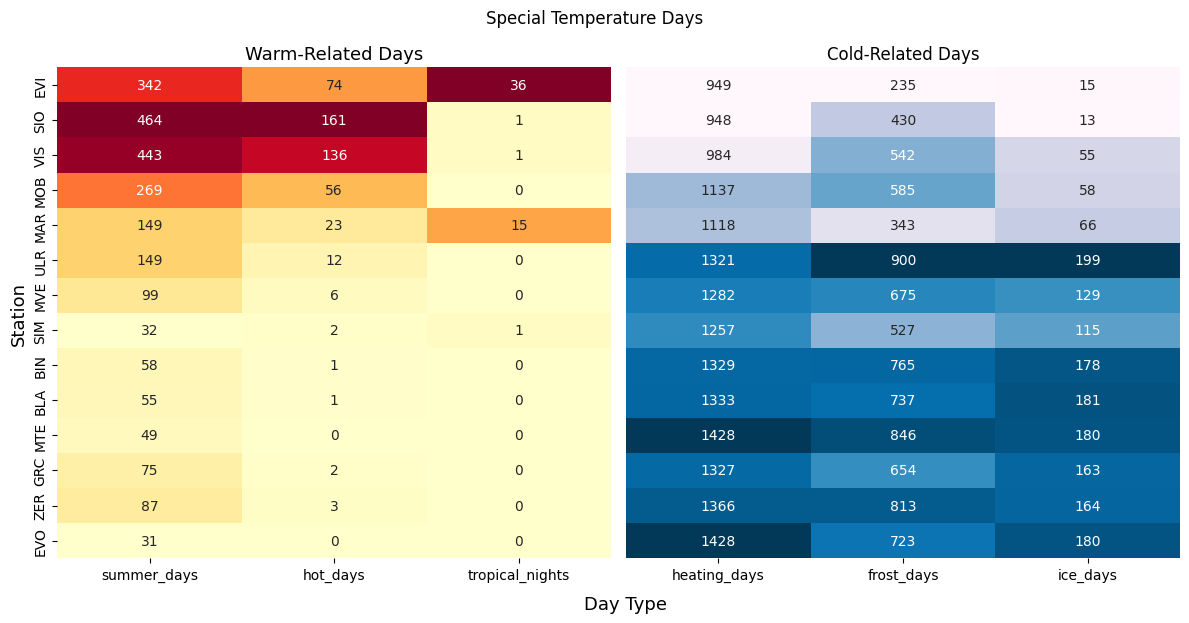

In [108]:
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define cold and warm day types (order matters!)
cold_cols = ['heating_days', 'frost_days', 'ice_days']
warm_cols = ['summer_days', 'hot_days', 'tropical_nights']

# Extract subsets
colds = summary_counts[cold_cols]
warms = summary_counts[warm_cols]

# Normalize each subset column-wise
scaler = MinMaxScaler()
norm_colds = pd.DataFrame(scaler.fit_transform(colds), columns=cold_cols, index=colds.index)
norm_warms = pd.DataFrame(scaler.fit_transform(warms), columns=warm_cols, index=warms.index)

# Plot side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))

sns.heatmap(norm_warms, annot=warms, cmap="YlOrRd", fmt='d', ax=ax1, cbar=False)
ax1.set_title("Warm-Related Days", fontsize=13)
ax1.set_xlabel("")
ax1.set_ylabel("Station", fontsize=13)

sns.heatmap(norm_colds, annot=colds, cmap="PuBu", fmt='d', ax=ax2, cbar=False)
ax2.set_title("Cold-Related Days", fontsize=12)
ax2.set_xlabel("")
ax2.tick_params(axis='y', length=0)
ax2.set_ylabel("")

plt.suptitle("Special Temperature Days", fontsize=12)
fig.text(0.525, -0.02, "Day Type", ha='center', fontsize=13)
plt.tight_layout()
plt.savefig("../../report/figures/special_days_heatmap.pdf", bbox_inches='tight')
plt.show()

## Wind direction

In [113]:
winds_inter = df_valais[['time', 'station', 'East', 'North']].copy()
winds_inter = winds_inter.merge(station_list, on='station', how='left')

wind_vec = winds_inter[winds_inter['North_bool']]
wind_vec

,time,station,East,North,name,east,north,altitude,Canton,precip_bool,temperature_bool,pression_bool,moisture_bool,North_bool,East_bool
788832,201901010000,BIN,1.28,0.96,Binn,657996,135422,1479,VS,True,True,False,True,True,True
788833,201901010010,BIN,1.80,0.80,Binn,657996,135422,1479,VS,True,True,False,True,True,True
788834,201901010020,BIN,1.76,1.10,Binn,657996,135422,1479,VS,True,True,False,True,True,True
788835,201901010030,BIN,2.16,1.20,Binn,657996,135422,1479,VS,True,True,False,True,True,True
788836,201901010040,BIN,1.62,0.90,Binn,657996,135422,1479,VS,True,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12621307,202312312310,ZER,2.45,2.45,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True
12621308,202312312320,ZER,1.56,2.08,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True
12621309,202312312330,ZER,1.44,1.92,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True
12621310,202312312340,ZER,1.50,2.00,Zermatt,624298,97574,1638,VS,True,True,True,True,True,True


In [114]:
wind_vec[['station', 'East', 'North']].groupby('station').mean()

,East,North
station,,
BIN,0.435216,0.331082
BLA,0.303736,0.120570
EVI,-0.134561,0.097100
EVO,-0.059877,0.380656
MAR,-0.159670,0.176114
MOB,-0.061274,0.149472
MTE,0.028024,-0.435495
MVE,-0.005506,0.504916
SIM,-1.513348,1.466706


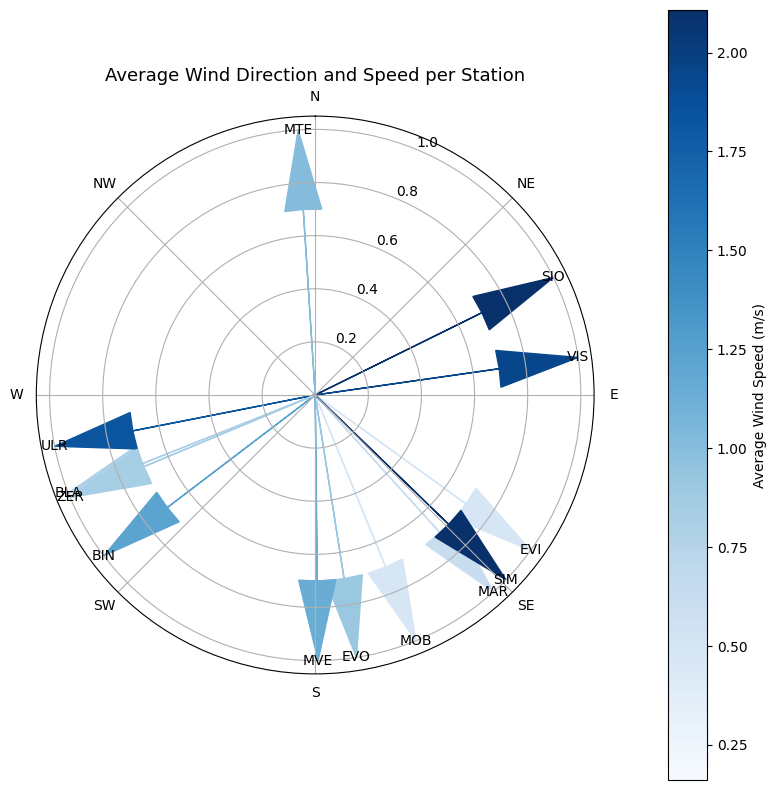

In [122]:
average_vec = wind_vec[['station', 'East', 'North']].groupby('station').mean()
average_vec['theta'] = np.arctan2(-average_vec['East'], -average_vec['North'])
average_vec['magnitude'] = np.sqrt(average_vec['East']**2 + average_vec['North']**2)
angles = np.arange(0, 360, 45)
labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

norm = mcolors.Normalize(vmin=average_vec['magnitude'].min(),
                         vmax=average_vec['magnitude'].max())
cmap = cm.Blues

# Plot in polar
fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(8, 8))

for _,row in average_vec.iterrows():
    color = cmap(row['magnitude'])
    ax.arrow(row['theta'], 0, 0, 1,
             length_includes_head=True,
             head_width=0.2,
             color=color)
    ax.text(row['theta'], 1, row.name, ha='center', va='center')
ax.set_title("Average Wind Direction and Speed per Station", fontsize=13)
ax.set_theta_zero_location('N')  # Puts 0° (North) at the top
ax.set_theta_direction(-1) 
ax.set_thetagrids(angles, labels)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for older matplotlib versions
cbar = plt.colorbar(sm, ax=ax, pad=0.1)
cbar.set_label("Average Wind Speed (m/s)")

plt.tight_layout()
plt.savefig('../../report/figures/wind_direction.pdf')
plt.show()

## Humidity

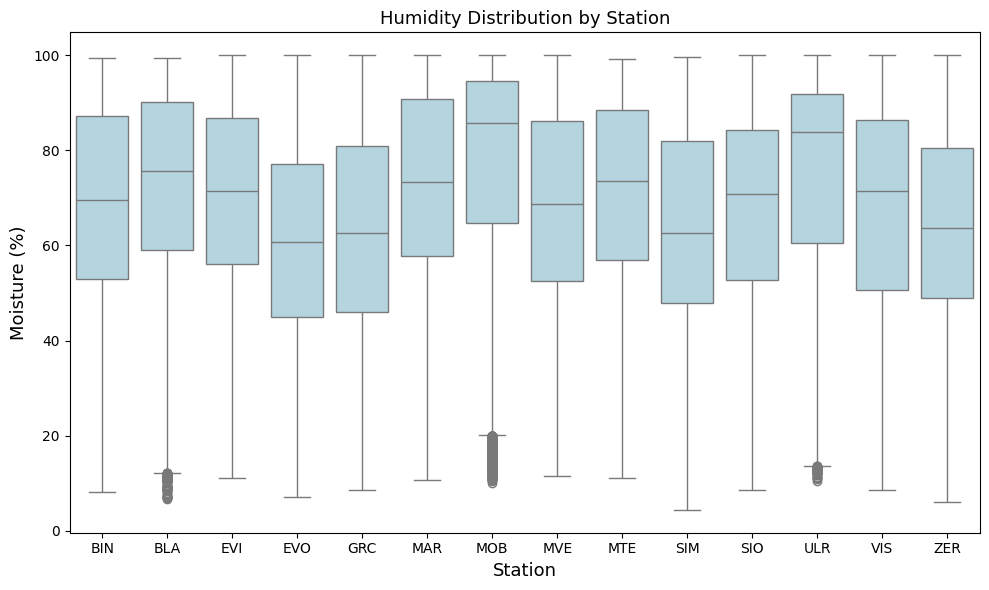

In [133]:
humidity = df_valais[['moisture', 'station']].copy()
humid_stat = station_list[station_list['moisture_bool']]
humidity = humidity[humidity['station'].isin(humid_stat['station'])]

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=humidity, x='station', y='moisture', ax=ax, color='lightblue')

ax.set_title("Humidity Distribution by Station", fontsize=13)
ax.set_xlabel("Station", fontsize=13)
ax.set_ylabel("Moisture (%)", fontsize=13)

plt.tight_layout()
plt.savefig('../../report/figures/humidity_by_station.pdf')
plt.show()

In [161]:
table = (humidity
            .merge(station_list[['station', 'altitude']], on='station', how='left')
            .groupby('station')
            .describe())
table

moisture                                                       \
            count       mean        std   min   25%   50%   75%    max   
station                                                                  
BIN      262638.0  68.966737  20.689452   8.1  53.0  69.6  87.2   99.3   
BLA      262944.0  72.561581  20.425225   6.8  59.0  75.6  90.2   99.3   
EVI      262621.0  70.336533  19.088401  11.1  56.0  71.4  86.8  100.0   
EVO      262944.0  61.366052  20.431114   7.2  45.0  60.7  77.2  100.0   
GRC      262800.0  63.386231  21.250798   8.6  46.1  62.6  80.8  100.0   
MAR      262891.0  72.675319  19.252711  10.7  57.7  73.4  90.7  100.0   
MOB      262944.0  77.982902  20.398027  10.1  64.7  85.8  94.5  100.0   
MTE      262944.0  71.207197  19.293747  11.1  57.0  73.5  88.5   99.2   
MVE      262944.0  68.205764  20.107985  11.6  52.5  68.6  86.2  100.0   
SIM      262783.0  64.039596  21.952932   4.4  47.9  62.7  82.0   99.5   
SIO      262944.0  67.751919  19.433502   8.6  52.7  70.9  84.3  100.0   
ULR      262944.0  75.607757  20.267514  10.4  60.6  83.9  91.9  100.0   
VIS      262033.0  67.848265  21.099176   8.6  50.6  71.4  86.3  100.0   
ZER      261885.0  63.981792  20.478533   6.1  48.9  63.7  80.4  100.0   

         altitude                                                       
            count    mean  std     min     25%     50%     75%     max  
station                                                                 
BIN      262944.0  1479.0  0.0  1479.0  1479.0  1479.0  1479.0  1479.0  
BLA      262944.0  1538.0  0.0  1538.0  1538.0  1538.0  1538.0  1538.0  
EVI      262944.0   482.0  0.0   482.0   482.0   482.0   482.0   482.0  
EVO      262944.0  1825.0  0.0  1825.0  1825.0  1825.0  1825.0  1825.0  
GRC      262944.0  1605.0  0.0  1605.0  1605.0  1605.0  1605.0  1605.0  
MAR      262944.0   990.0  0.0   990.0   990.0   990.0   990.0   990.0  
MOB      262944.0   839.0  0.0   839.0   839.0   839.0   839.0   839.0  
MTE      262944.0  1580.0  0.0  1580.0  1580.0  1580.0  1580.0  1580.0  
MVE      262944.0  1422.0  0.0  1422.0  1422.0  1422.0  1422.0  1422.0  
SIM      262944.0  1465.0  0.0  1465.0  1465.0  1465.0  1465.0  1465.0  
SIO      262944.0   482.0  0.0   482.0   482.0   482.0   482.0   482.0  
ULR      262944.0  1345.0  0.0  1345.0  1345.0  1345.0  1345.0  1345.0  
VIS      262944.0   639.0  0.0   639.0   639.0   639.0   639.0   639.0  
ZER      262944.0  1638.0  0.0  1638.0  1638.0  1638.0  1638.0  1638.0

In [157]:
print(table.to_latex(index=True, 
                           caption="Descriptive statistics for humidity by station", 
                           label="tab:desc_humidity",
                           float_format="{:.2f}".format))

\begin{table}
\caption{Descriptive statistics for humidity by station}
\label{tab:desc_humidity}
\begin{tabular}{lrrrrrrrr}
\toprule
 & \multicolumn{8}{r}{moisture} \\
 & count & mean & std & min & 25% & 50% & 75% & max \\
station &  &  &  &  &  &  &  &  \\
\midrule
BIN & 262638.00 & 68.97 & 20.69 & 8.10 & 53.00 & 69.60 & 87.20 & 99.30 \\
BLA & 262944.00 & 72.56 & 20.43 & 6.80 & 59.00 & 75.60 & 90.20 & 99.30 \\
EVI & 262621.00 & 70.34 & 19.09 & 11.10 & 56.00 & 71.40 & 86.80 & 100.00 \\
EVO & 262944.00 & 61.37 & 20.43 & 7.20 & 45.00 & 60.70 & 77.20 & 100.00 \\
GRC & 262800.00 & 63.39 & 21.25 & 8.60 & 46.10 & 62.60 & 80.80 & 100.00 \\
MAR & 262891.00 & 72.68 & 19.25 & 10.70 & 57.70 & 73.40 & 90.70 & 100.00 \\
MOB & 262944.00 & 77.98 & 20.40 & 10.10 & 64.70 & 85.80 & 94.50 & 100.00 \\
MTE & 262944.00 & 71.21 & 19.29 & 11.10 & 57.00 & 73.50 & 88.50 & 99.20 \\
MVE & 262944.00 & 68.21 & 20.11 & 11.60 & 52.50 & 68.60 & 86.20 & 100.00 \\
SIM & 262783.00 & 64.04 & 21.95 & 4.40 & 47.90 & 62.70 &

C:\Users\elwin\AppData\Local\Temp\ipykernel_3096\1376645609.py:41: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\elwin\Desktop\MeteoThesis\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


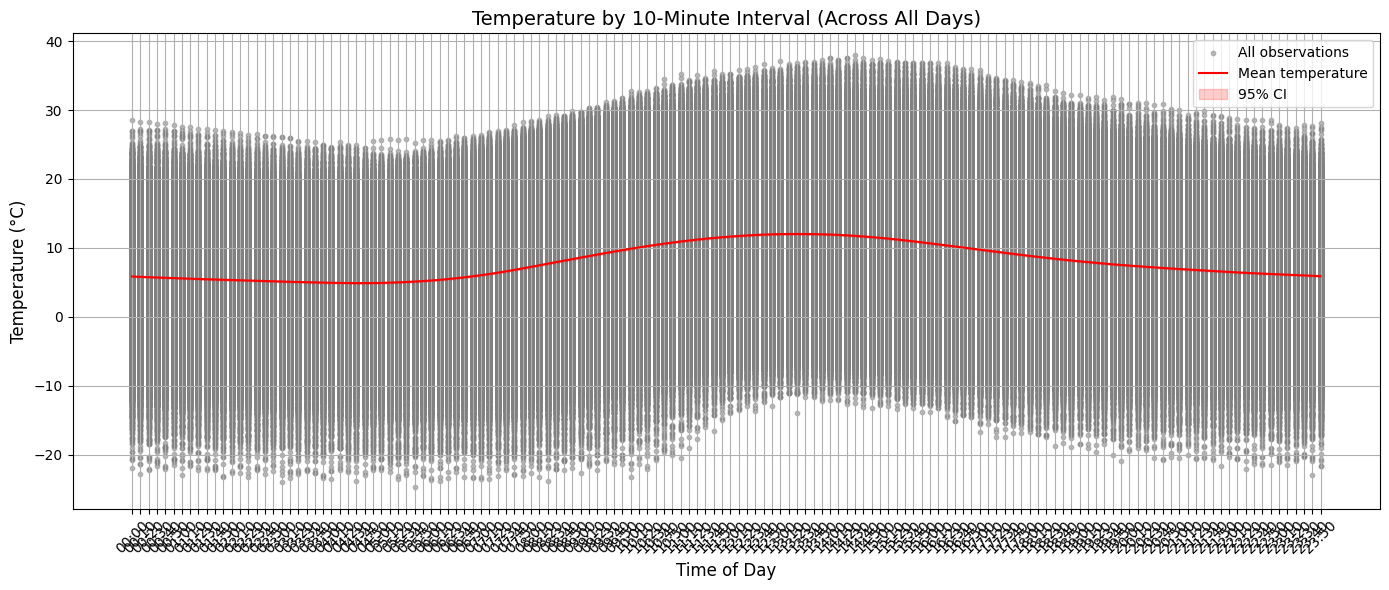

In [145]:
# Copy and slice the time string to get HH:MM
temperature = df_valais[['temperature', 'station', 'time']].copy()
temperature['time'] = temperature['time'].astype('string')
temperature['hhmm'] = temperature['time'].str.slice(start=8, stop=10) + ':' + temperature['time'].str.slice(start=10)

# Group by 10-minute intervals (HH:MM)
grouped = temperature.groupby('hhmm')['temperature']
mean_temp = grouped.mean()
std_temp = grouped.std()
count = grouped.count()
sem = std_temp / np.sqrt(count)
ci_upper = mean_temp + 1.96 * sem
ci_lower = mean_temp - 1.96 * sem

# Get time-of-day intervals in correct order
time_labels = sorted(temperature['hhmm'].unique())

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Scatter: all temperature observations
ax.scatter(temperature['hhmm'], temperature['temperature'],
           color='gray', alpha=0.5, s=10, label='All observations')

# Mean line
ax.plot(time_labels, mean_temp.reindex(time_labels), color='red', label='Mean temperature')

# Confidence interval shading
ax.fill_between(time_labels,
                ci_lower.reindex(time_labels),
                ci_upper.reindex(time_labels),
                color='red', alpha=0.2, label='95% CI')

# Formatting
ax.set_title("Temperature by 10-Minute Interval (Across All Days)", fontsize=14)
ax.set_xlabel("Time of Day", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.legend()
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Graphs not used

In [ ]:
valais_stations = ["SIO","VSSIE", "ZER", "VSDER", "VIS"]
station_name = ["Sion", "Sierre", "Zermatt", "Derborence", "Visp"]

precip_filter = df_valais[df_valais['station'].isin(valais_stations)]
precip_wide = precip_filter.pivot(index='time', columns='station', values='precip')

precip_wide.index = pd.to_datetime(precip_wide.index, format='%Y%m%d%H%M')

monthly_precip = precip_wide.resample('ME').sum()
bar_width = 0.19
x = np.arange(len(monthly_precip.index))

fig, ax = plt.subplots(figsize=(12,6))

for i, (station, name) in enumerate(zip(valais_stations, station_name)):
    ax.bar(x + i* bar_width, monthly_precip[station], width=bar_width, label=name)

ax.set_xticks(x + (bar_width * (len(valais_stations) / 2)))
ax.set_xticklabels(monthly_precip.index.strftime('%Y-%m'), rotation=45)    
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("Precipitation (mm)", fontsize=13)
ax.set_title("Monthly precipitation total for selected stations", fontsize=13)
ax.legend(loc="upper right", ncol=1, fontsize=8)
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("report/figures/monthly_valais_bar.pdf")
plt.show()

In [ ]:
    # Filter data for the selected station
    temp_filter = temperature[temperature['station'] == station]

    # Convert 'time' column to datetime
    temp_filter['time'] = pd.to_datetime(temp_filter['time'], format='%Y%m%d%H%M')

    # Extract the year and reset the index to maintain order of data points
    temp_filter['year'] = temp_filter['time'].dt.year
    temp_filter['day_of_year'] = temp_filter['time'].dt.dayofyear  # Day of the year (1 to 365/366)

    # Get the list of unique years in the dataset
    years = temp_filter['year'].unique()

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each year's data, each as a separate line
    for year in years:
        # Filter data for each year
        temp_year = temp_filter[temp_filter['year'] == year]
        
        # Plot the temperature values, using 'day_of_year' on the x-axis
        ax.plot(temp_year['day_of_year'], temp_year['temperature'], label=str(year))

    # Set labels and title
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Temperature (°C)")
    ax.set_title(f"Temperature Comparison for {station} by Year")

    # Adding legend and grid
    ax.legend(loc="upper left", ncol=1, fontsize=8)
    ax.grid(True, linestyle="--", alpha=0.5)

    # Tight layout and show plot
    plt.tight_layout()
    plt.show()
    
    # Save the plot to a file
    #plt.savefig(f"report/figures/monthly_temp_pully.pdf")

In [ ]:
precip_filter = precip[precip['station']==station]

precip_filter.index = pd.to_datetime(precip_filter['time'], format='%Y%m%d%H%M')

years = precip_filter.index.year.unique()
fig, ax = plt.subplots(figsize=(12,6))

for i, year in enumerate(years):
    precip_year = precip_filter[precip_filter.index.year == year]
    cumsum = precip_year['precipitation'].cumsum
    ax.plot(cumsum.index, cumsum, color=cmap(i))

ax.set_xlabel("Time")
ax.set_ylabel("Precipitation (mm)")
ax.set_title("Yearly Cumulative precipitation over Pully")
ax.legend(loc="upper right", ncol=1, fontsize=8)
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
plt.savefig("report/figures/overlap_cumsum.pdf")
